# Kickstarter Project Success Prediction

### Background: 
I have been interested in crowdfunding and the opportunities it creates for people to start their businesses. Kickstarter is one of the largest platforms on the web that allows entrepreneurs to share their ideas with many potential investors. Although, thousands of projects get listed, a large proportion of them fail to become successful. I wanted to see what factors contribute to this outcome.

### Problem: 
Can we predict the success of a project on [Kickstarter](https://www.kickstarter.com/) given widely accessible project characteristics?

### Approach: 
Build a binary classification model which can accurately determine whether the project will fail or succeed.

### Data Sources:
The data have been scraped by the [Webroots](https://webrobots.io/kickstarter-datasets/) for the date of 2018-02-15. 

### Table of Contents:
- 1.[Dependencies/Data Import](#section_1)
- 2.[Data Cleaning](#section_2)
- 3.[Data Exploration](#section_3)
- 4.[Preprocessing](#section_4)
- 5.[Modeling](#section_5)
- 6.[Conclusion](#section_6)

<a id='section_1'></a>

## 1. Dependencies/Data Import

In [1]:
#Import all the libraries we will need in this workbook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#Set styles for how to display dataframes and plots 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
sns.set(style="whitegrid")
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#Import the data. Since there are 49 separate csv files, we will use 2 for loops to append each one to the data frame
df=pd.DataFrame(pd.read_csv("Kickstarter.csv"))
for i in range(1,10):
    df=df.append(pd.read_csv("Kickstarter00" + str(i) + ".csv"))
for i in range(11,49):
    df=df.append(pd.read_csv("Kickstarter0" + str(i) + ".csv"))
df=df.reset_index(drop=True)

<a id='section_2'></a>

## 2. Data Cleaning

Now that we have our data, we need to learn more about it. Specifically, how many dependent/independent variables are there, what are their data types, what issues do we need to fix?

In [3]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions
0,80,I will be an artist-in-residence at Elsewhere ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3596,US,1325980505,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334866560,False,1.00,2800.00,1562040083,False,1332969260,Elsewhere Studios artist-in-residency program!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3596.00,"{""background_image_opacity"":0.8,""should_show_f...",elsewhere-studios-artist-in-residency-program,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334866560,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3596.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
1,47,We are looking to bring a Visiting Sculptor fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4117,US,1330727362,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334959598,False,1.00,3900.00,1437561817,False,1332972398,Martin Luther King Jr. Sculpture on Campus!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4117.00,"{""background_image_opacity"":0.8,""should_show_f...",martin-luther-king-jr-sculpture-on-campus,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334959598,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4117.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
2,80,Surrealistic oil paintings capturing the metam...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3125,US,1332598567,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334635140,False,1.00,750.00,574125813,False,1332975679,EMERGENCE: Surreal Oil Paintings by J.J. Long,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3125.00,"{""background_image_opacity"":0.8,""should_show_f...",emergence-surreal-oil-paintings-by-jj-long,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334635143,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3125.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
3,82,1000 Artists is a public art-making installati...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4586,US,1330926084,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1336440145,False,1.00,4500.00,858990141,False,1332984145,1000 Artists: Presidential Inauguration 2013,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4586.00,"{""background_image_opacity"":0.8,""should_show_f...",1000-artists-presidential-inauguration-2013,https://www.kickstarter.com/discover/categorie...,True,False,successful,1336440145,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4586.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",1036,US,1332476607,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1333421843,False,1.00,1000.00,566704999,False,1332989843,P.M.A.F.T.W.,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",1036.00,"{""background_image_opacity"":0.8,""should_show_f...",pmaftw,https://www.kickstarter.com/discover/categorie...,True,False,successful,1333421843,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",1036.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN


In [4]:
df.shape

(191573, 37)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191573 entries, 0 to 191572
Data columns (total 37 columns):
backers_count               191573 non-null int64
blurb                       191562 non-null object
category                    191573 non-null object
converted_pledged_amount    191573 non-null int64
country                     191573 non-null object
created_at                  191573 non-null int64
creator                     191573 non-null object
currency                    191573 non-null object
currency_symbol             191573 non-null object
currency_trailing_code      191573 non-null bool
current_currency            191573 non-null object
deadline                    191573 non-null int64
disable_communication       191573 non-null bool
fx_rate                     191573 non-null float64
goal                        191573 non-null float64
id                          191573 non-null int64
is_starrable                191573 non-null bool
launched_at                 191

In [6]:
df.isnull().sum()

backers_count                    0
blurb                           11
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
fx_rate                          0
goal                             0
id                               0
is_starrable                     0
launched_at                      0
name                             1
photo                            0
pledged                          0
profile                          0
slug                             0
source_url                       0
spotlight                        0
staff_pick                       0
state                            0
state_changed_at                 0
static_usd_rate     

We can see that 4 of the 37 columns contain primarily NaN values. We will remove them because the process of recovering information from a small subset is difficult and is unlikely to produce useful results. Next, we will also remove features associated with images, descriptions and urls since NLP is not the main purpose of this exercise. Finally, we will remove the features which do not provide us with interesting information, or help us improve the model.

##### We will be using these features:
- category - the category a specific project falls under (used to obtain subcategory)
- country - the country from which the project originated
- location - the city from which the project originated
- disable_communication - the status which indicates whether project creators disabled communication with backers
- goal - the amount of funding a project needs to achieve
- staff_pick - the status which indicates whether the project gained interest from Kickstarter staff
- launched_at - the date on which the project started the crowdfunding campaign (used to calculate project duration)
- deadline - the date by which the project has to reach its goal (used to calculate project duration)
- state - the status which indicates whether the project is successful or not **(the output we are trying to predict)**

In [7]:
#Drop all projects which are currently live
df=df.drop(df[df.state=='live'].index).reset_index(drop=True)

#Assign projects which do not have a location to a new group called 'Other'
df.location=df.location.fillna('short_name":"Other')

#Extract categories, subcategories, locations and dates from large string values
cat, sub, loc, duration=[],[],[],[]
for i in range(0,len(df)):
    sub.append(re.search('(?<="name":")\w+(.[a-zA-Z]+)(.[a-zA-Z]+)?', df.category.iloc[i]).group())
    cat.append(re.search('(?<="slug":")\w+', df.category.iloc[i]).group().capitalize())
    loc.append(re.search('(?<=short_name":")(....)?[-]?([a-zA-Z]+)?\s?[-]?([a-zA-Z]+)?', df.location.iloc[i]).group())
    duration.append(abs((datetime.strptime(datetime.fromtimestamp(df.deadline[i]).strftime('%Y-%m-%d'),'%Y-%m-%d') 
                 - datetime.strptime(datetime.fromtimestamp(df.launched_at[i]).strftime('%Y-%m-%d'),'%Y-%m-%d'))).days)

#Substitute the formatted columns instead of the original ones
df['category'], df['subcategory'], df['location'], df['duration'] = cat, sub, loc, duration

In [8]:
#Select only the features that we need
df=df[['category', 'country', 'location', 'disable_communication', 'goal', 'staff_pick',
       'subcategory', 'duration', 'state']]

In [9]:
df.isnull().sum()

category                 0
country                  0
location                 0
disable_communication    0
goal                     0
staff_pick               0
subcategory              0
duration                 0
state                    0
dtype: int64

It seems that we were able to clear out most of the NaN values and obtain relevant data. However, we are not done yet. For a binary classification problem we need to make sure that our training and test data only have 2 output values.

In [10]:
df.state.unique()

array(['successful', 'canceled', 'failed', 'suspended'], dtype=object)

Because canceled and suspended projects did not succeed, we will assign them to the 'failed' state. This will allow us to keep the data, while restricting the output to the positive and negative class

In [11]:
#Replace all canceled and suspended projects with 'failed' state
df.state=list(map(lambda x: x.replace('canceled', 'failed') , df.state))
df.state=list(map(lambda x: x.replace('suspended', 'failed') , df.state))

In [12]:
df.head()

,category,country,location,disable_communication,goal,staff_pick,subcategory,duration,state
0,Art,US,Paonia,False,2800.00,False,Mixed Media,22,successful
1,Art,US,Bakersfield,False,3900.00,False,Art,23,successful
2,Art,US,Lowell,False,750.00,False,Painting,19,successful
3,Art,US,Washington,False,4500.00,False,Public Art,40,successful
4,Art,US,Portland,False,1000.00,False,Painting,5,successful


<a id='section_3'></a>

## 3. Data Exploration

Since our data has now been properly cleaned and formatted, we can proceed to the next step and get to know it a little bit better.

In [13]:
df.groupby('state').state.count()

state
failed         81521
successful    103474
Name: state, dtype: int64

### Location

Text(0.5,0,'Project Count')

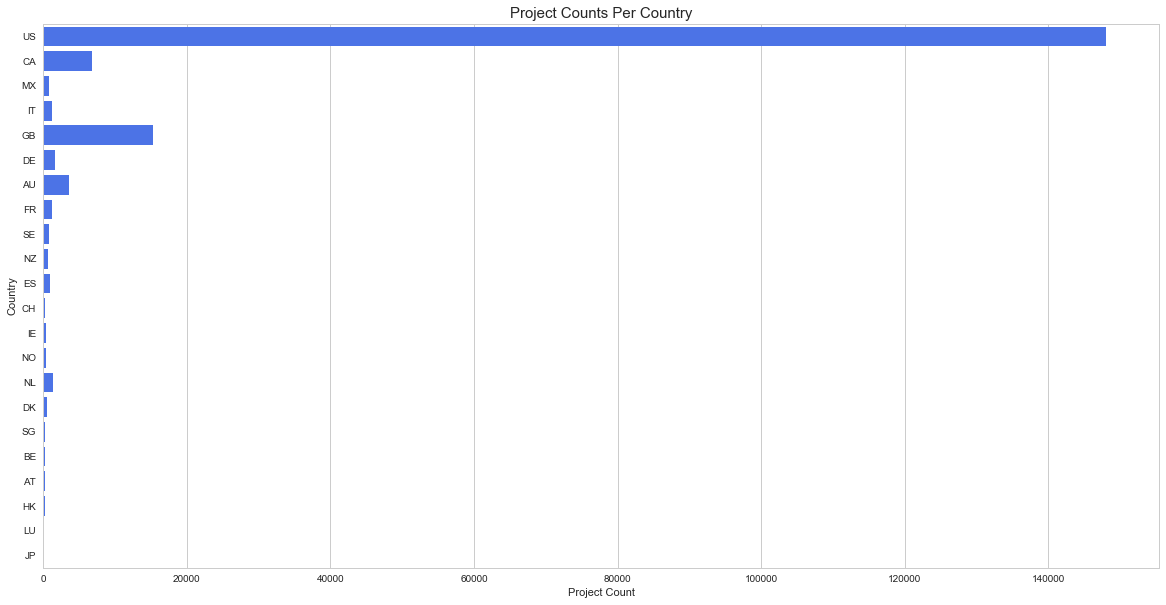

In [14]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="country", data=df, color='#3366ff')
plt.title('Project Counts Per Country', fontsize=15)
plt.ylabel('Country')
plt.xlabel('Project Count')

Text(0,0.5,'Country')

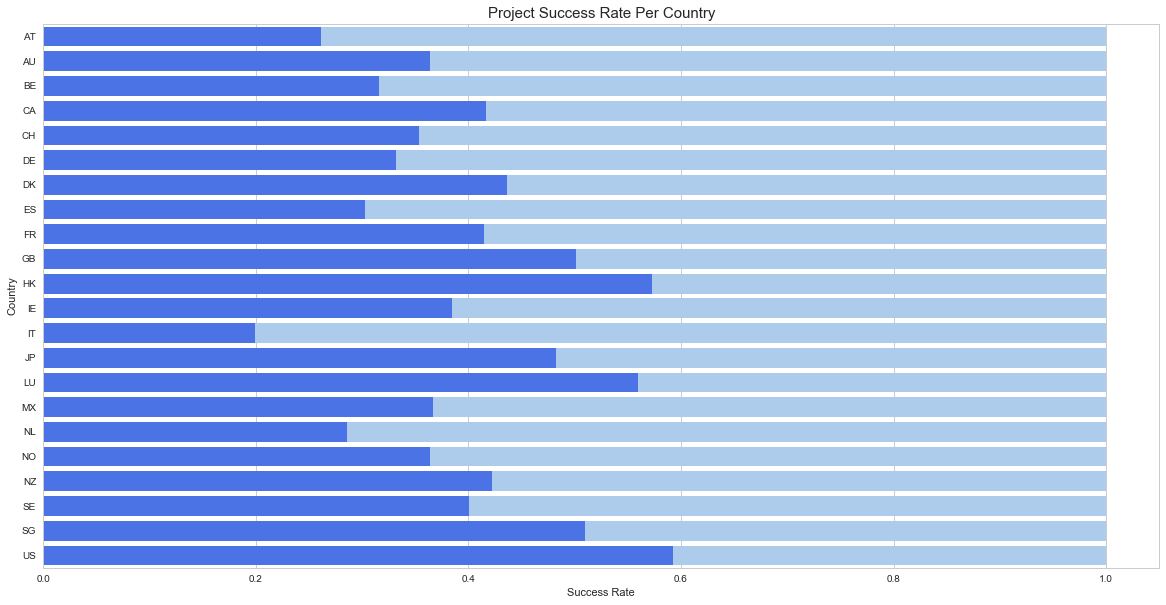

In [15]:
#Group country counts based on state
countries=df.groupby(['country', 'state']).count()['goal']
countries=countries[countries.index.get_level_values('state').isin(['successful', 'failed'])]

#Plot
plt.figure(figsize=(20,10))
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[1 for i in range(1,len(list(countries)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[countries[i]/(countries[i-1]+countries[i]) for i in range(1,len(list(countries)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate Per Country', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('Country')

From the above plots we can see that the vast majority of crowdfunding campaigns on Kickstarter originate from the United States. It is also the country with the highest proportion of successful campaigns. The wide discrepancy between the success rates in the U.S. and countries such as Italy, or Austria can potentially help our model better differentiate between observations. Lets take a deeper look at the locations and compare the largest cities.

Text(0,0.5,'City')

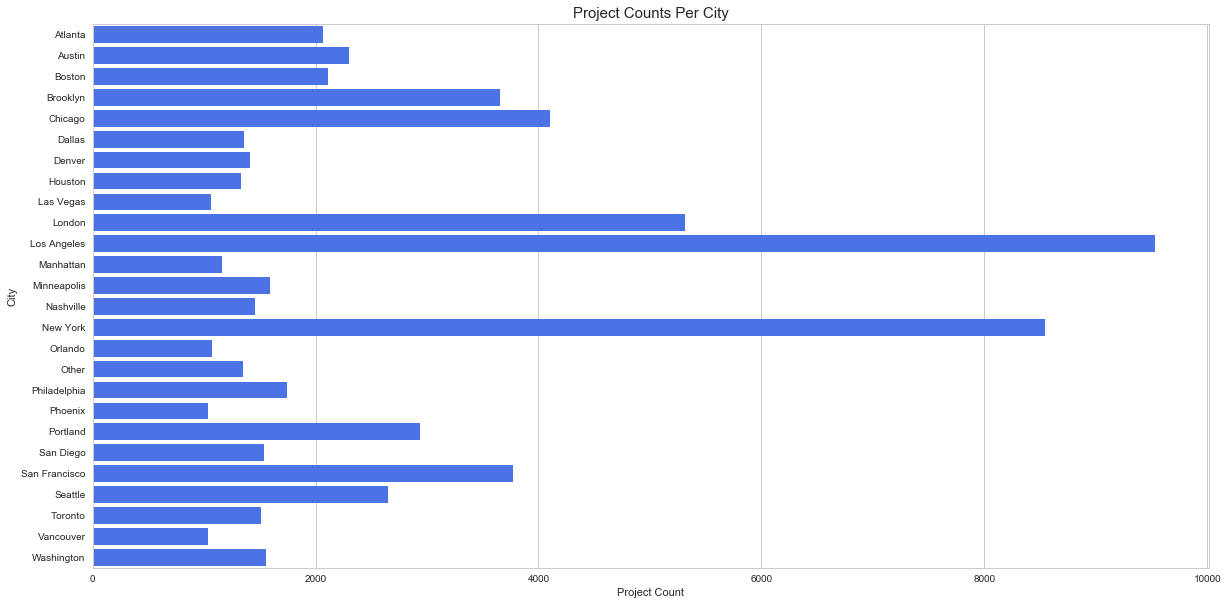

In [16]:
#Select cities that have counts of more than 1000 in the dataset
locn=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000].index)
locc=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000])

#Plot
plt.figure(figsize=(20,10))
sns.barplot(y=locn,x=locc,color='#3366ff',orient="h")
plt.title('Project Counts Per City', fontsize=15)
plt.xlabel('Project Count')
plt.ylabel('City')

Text(0,0.5,'City')

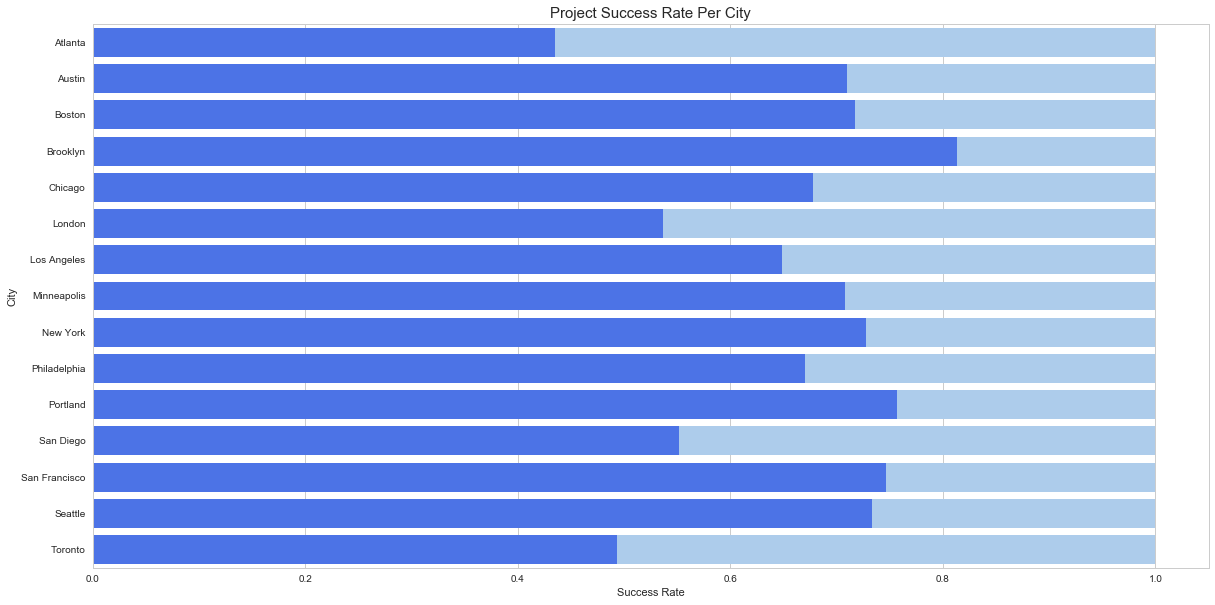

In [17]:
#Select the top 15 cities from above and plot
cts=df.groupby(['location', 'state']).count()['goal']
cts=cts[cts.index.get_level_values('state').isin(['successful', 'failed'])]
cts=cts[cts.index.get_level_values('location').isin(['New York', 'London', 'Los Angeles', 'Chicago', 
                                                       'San Francisco','Brooklyn','Portland', 'Seattle', 
                                                       'Austin', 'Boston', 'Atlanta', 'Philadelphia',
                                                       'Minneapolis','San Diego', 'Toronto'])]
#Plot
plt.figure(figsize=(20,10))
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[1 for i in range(1,len(list(cts)),2)],color='#a3ccf5',orient="h")
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[cts[i]/(cts[i-1]+cts[i]) for i in range(1,len(list(cts)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate Per City', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('City')

Once again, the U.S. cities seem to be leading the pack both in the popularity of Kickstarter projects and their success rates.

### Size

Text(0.5,0,'State')

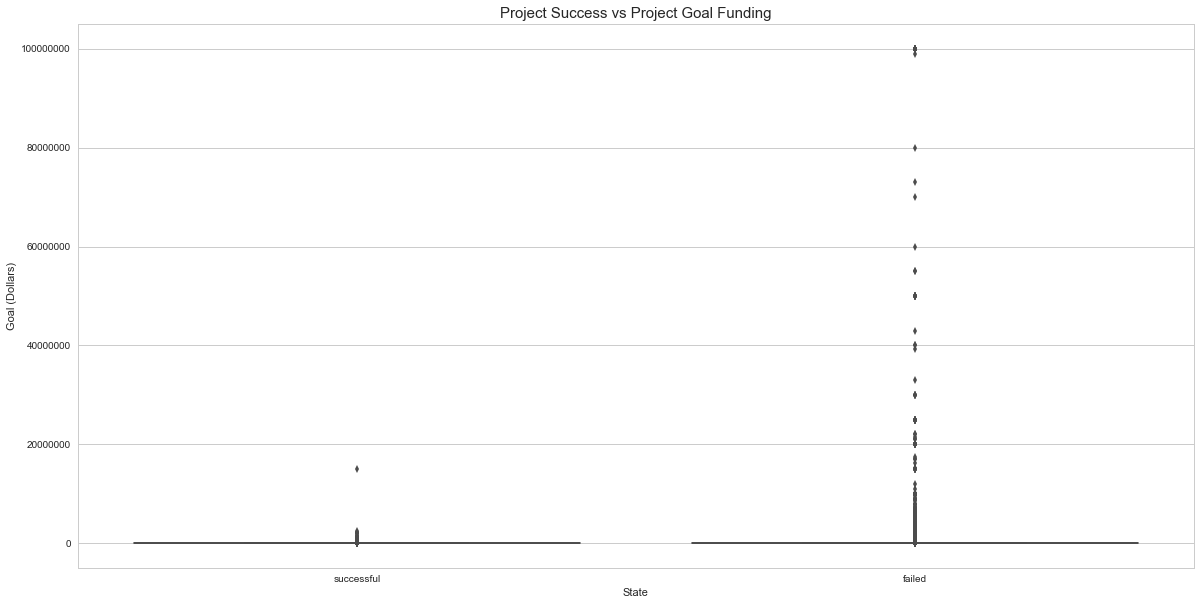

In [18]:
plt.figure(figsize=(20,10))
sns.boxplot(y='goal',x='state', data=df, color='b')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Project Success vs Project Goal Funding', fontsize=15)
plt.ylabel('Goal (Dollars)')
plt.xlabel('State')

In [19]:
df.goal[df.state=='successful'].describe()

count     103474.00
mean       10089.07
std        58904.53
min            0.01
25%         1200.00
50%         3500.00
75%         9200.00
max     15000000.00
Name: goal, dtype: float64

In [20]:
df.goal[df.state=='failed'].describe()

count       81521.00
mean        94800.45
std       1854100.49
min             1.00
25%          2500.00
50%          7000.00
75%         24000.00
max     100000000.00
Name: goal, dtype: float64

The box plots above have very significant skews (thanks to the influential outliers) and we cannot clearly observe the quartiles. However, they still provide some very interesting information. We can see that successful campaigns for the most part attempt to raise under 5 million  with an average of ~$10 thousand, while failed projects seem to disregard limits and try to raise up to 100 million with an average of ~95 thousand. This difference in goal amounts can be partially responsible for the difficulty people are facing with creating successful projects.  

### Categories

Text(0,0.5,'Category')

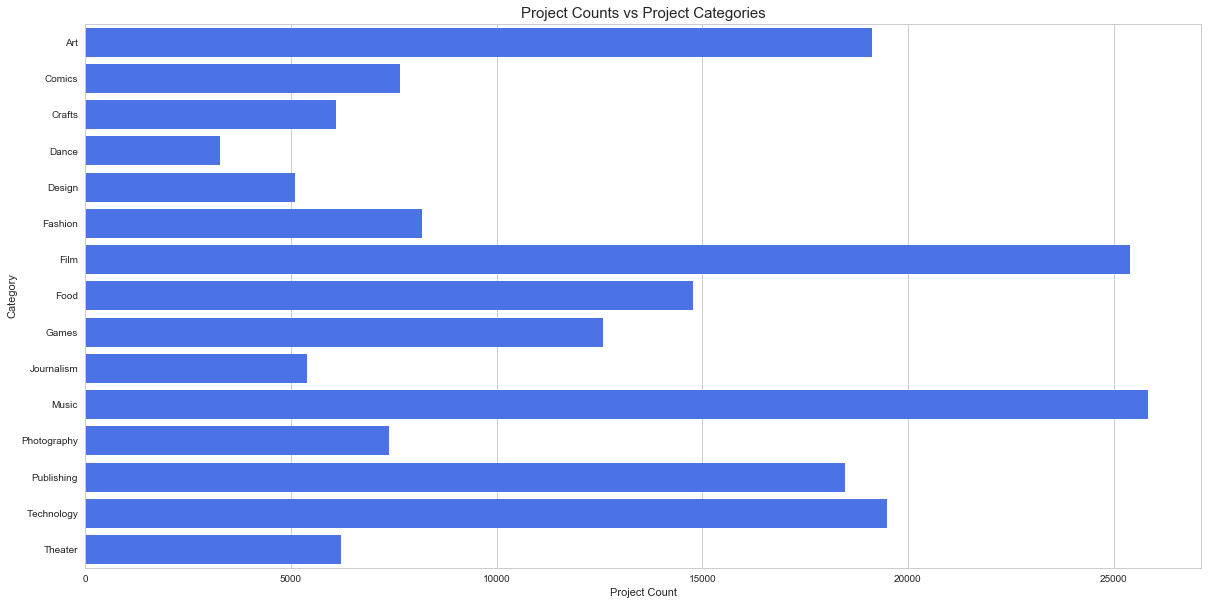

In [21]:
#Plot Categories
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="category", data=df, color='#3366ff')
plt.title('Project Counts vs Project Categories', fontsize=15)
plt.xlabel('Project Count')
plt.ylabel('Category')

Text(0,0.5,'Category')

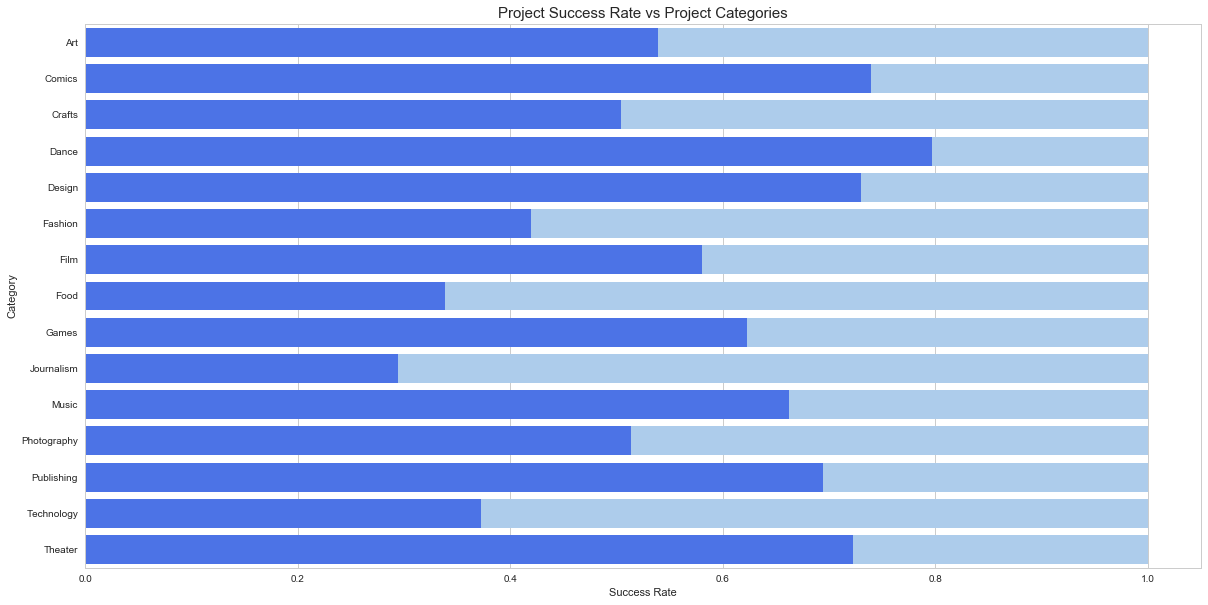

In [22]:
#Group the data by category counts and state
categories=df.groupby(['category', 'state']).count()['goal']
categories=categories[categories.index.get_level_values('state').isin(['successful', 'failed'])]

#Plot
plt.figure(figsize=(20,10))
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[1 for i in range(1,len(list(categories)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[categories[i]/(categories[i-1]+categories[i]) for i in range(1,len(list(categories)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Project Categories', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('Category')

Text(0,0.5,'Goal (Dollars)')

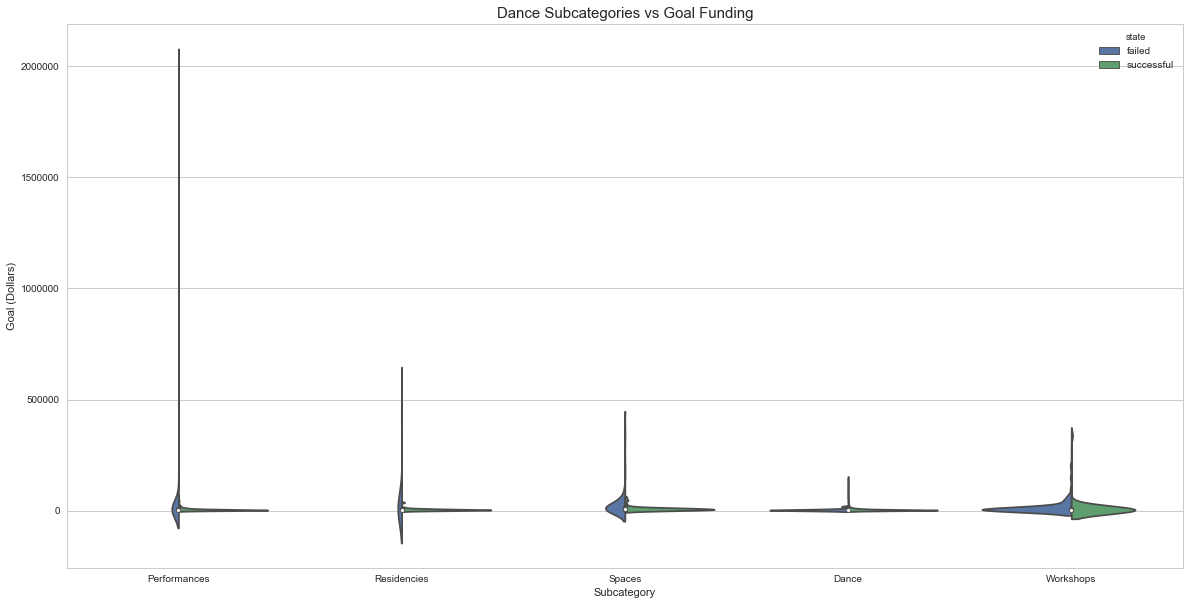

In [23]:
#Select the dance category for plotting
dance = df[df.category=='Dance']

#Plot
plt.figure(figsize=(20,10))
sns.violinplot(x="subcategory", y="goal", hue="state", data=dance, split=True)
plt.title('Dance Subcategories vs Goal Funding', fontsize=15)
plt.xlabel('Subcategory')
plt.ylabel('Goal (Dollars)')

Text(0,0.5,'Goal (Dollars)')

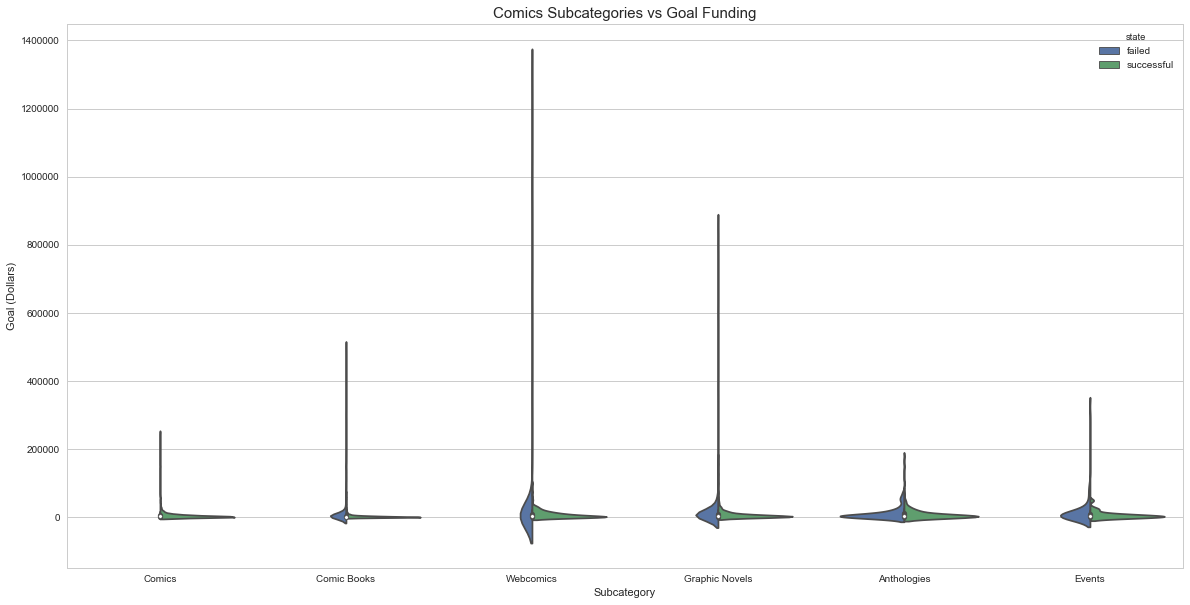

In [24]:
#Select the comics category for plotting
comics = df[df.category=='Comics']

#Plot
plt.figure(figsize=(20,10))
sns.violinplot(x="subcategory", y="goal", hue="state", data=comics, split=True, hue_order=['failed','successful'])
plt.title('Comics Subcategories vs Goal Funding', fontsize=15)
plt.xlabel('Subcategory')
plt.ylabel('Goal (Dollars)')

Just like the location plots, we can see that there are few categories and subcategories that stand out in popularity and success rates. In general, most projects fall under music, film, technology and publishing. However, the most successful project categories are the least popular dance, comics and theater.

### Duration

Text(0.5,0,'Success Rate')

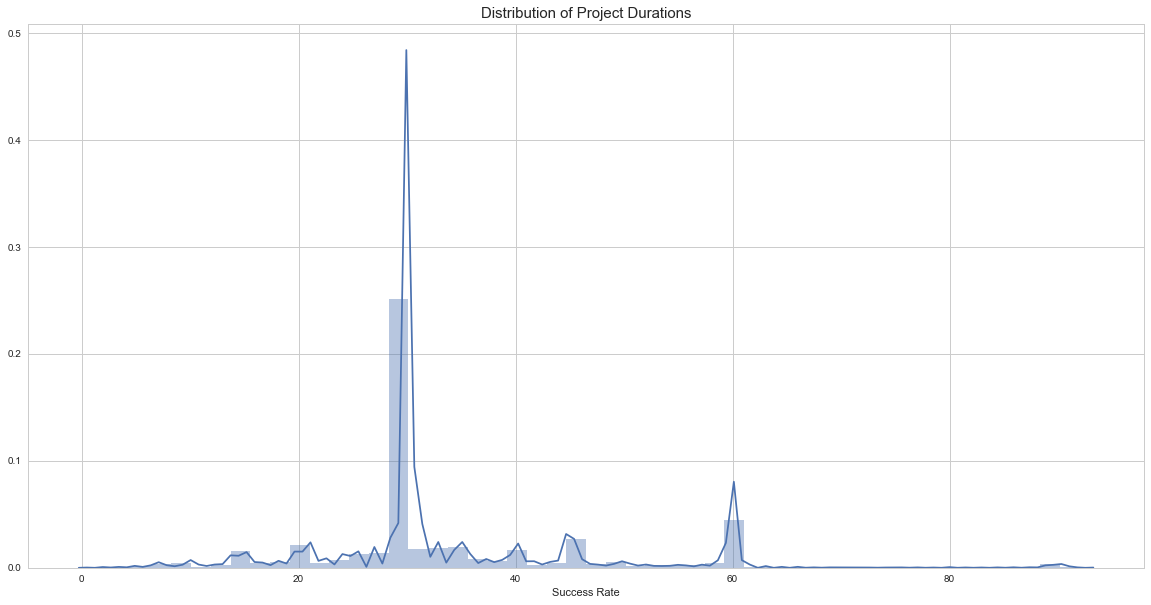

In [25]:
#Plot the distribution of campaign durations
plt.figure(figsize=(20,10))
sns.distplot(df.duration)
plt.title('Distribution of Project Durations', fontsize=15)
plt.xlabel('Success Rate')

Text(0.5,0,'Project Duration (Days)')

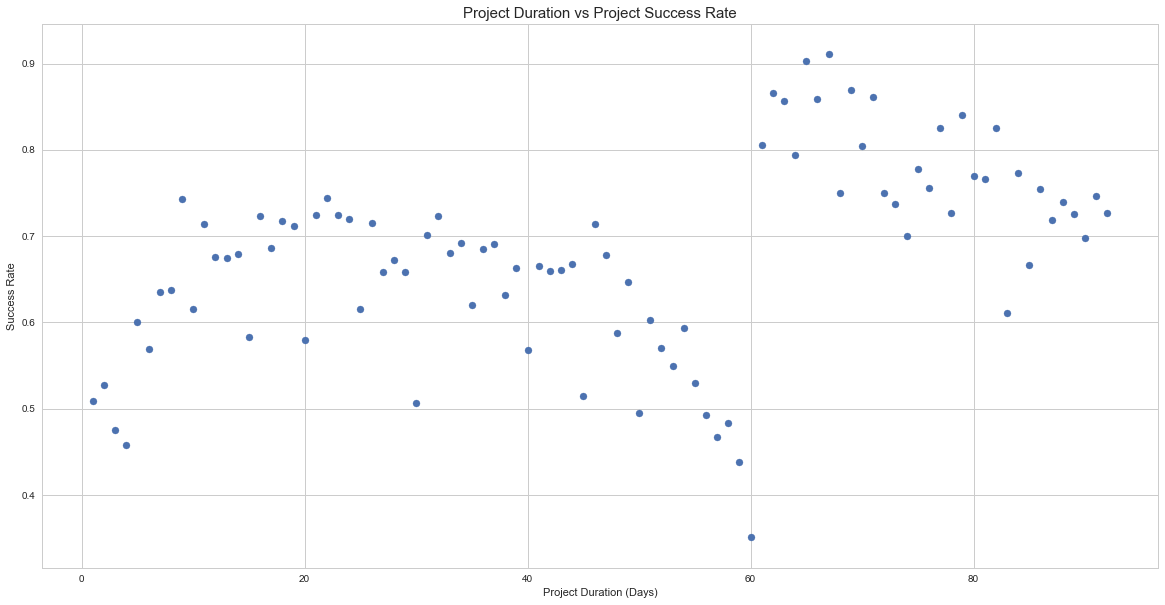

In [26]:
#Group counts of project durations based on state
durations=df.groupby(['duration', 'state']).count()['goal']
durations=durations[durations.index.get_level_values('state').isin(['successful', 'failed'])]

#Plot
plt.figure(figsize=(20,10))
plt.scatter(durations.index.get_level_values('duration').unique(),[list(durations)[i]/(list(durations)[i-1]+list(durations)[i]) for i in range(1,len(list(durations)),2)])
plt.title('Project Duration vs Project Success Rate', fontsize=15)
plt.ylabel('Success Rate')
plt.xlabel('Project Duration (Days)')

It appears that 30 day crowdfunding campaigns tend to be the most popular. The success rates appear to increase for campaigns that last 0-20 days, and gradually decrease for campaigns that last 40-60 days. Surprisingly, a linear model would not describe this data well as the relationship appears rather parabolic. Additionally, there is another separate cluster which breaks away from the first trend. It shows that projects which last for more than 60 day appear to have better success rates than any other group.  

### Misc.

Text(0.5,0,'Success Rate')

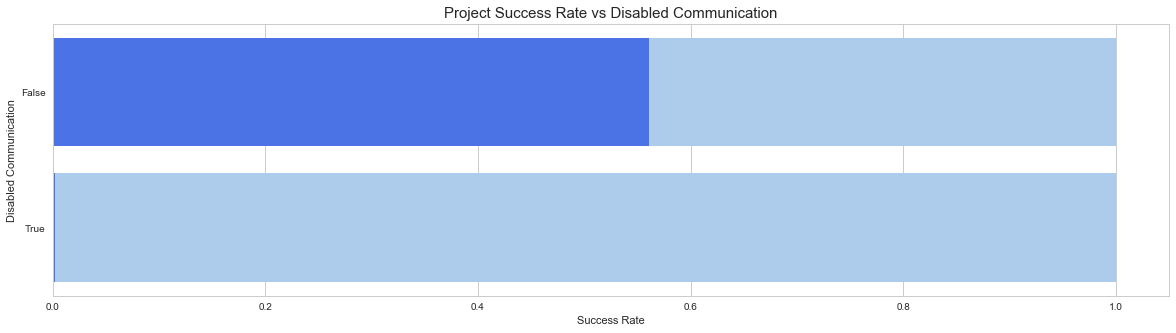

In [27]:
#Group the counts of disabled communications based on their state
coms=df.groupby(['disable_communication', 'state']).count()['goal']

#Plot
plt.figure(figsize=(20,5))
sns.barplot(y=coms.index.get_level_values('disable_communication').unique(),x=[1,1],color='#a3ccf5', orient="h")
sns.barplot(y=coms.index.get_level_values('disable_communication').unique(),
            x=[(coms[0][1]/(coms[0][0]+coms[0][1])), 1/coms[1]],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Disabled Communication', fontsize=15)
plt.ylabel('Disabled Communication')
plt.xlabel('Success Rate')

Text(0.5,0,'Success Rate')

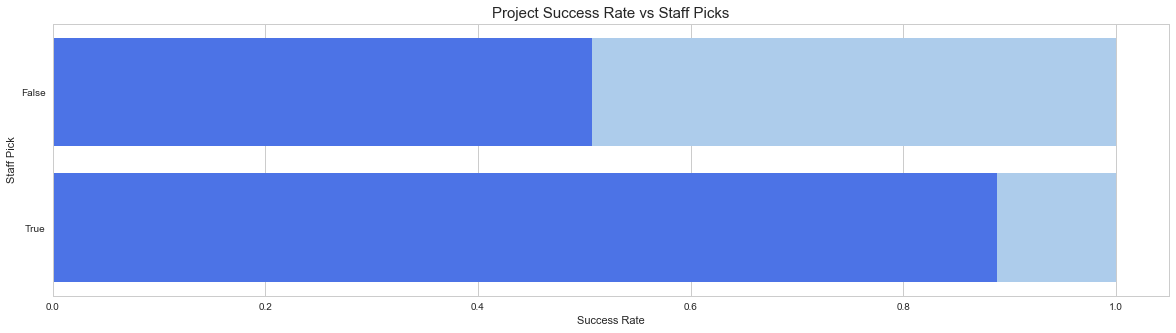

In [28]:
#Group the counts of projects that have been picked by staff based on their state
staff=df.groupby(['staff_pick', 'state']).count()['goal']

#Plot
plt.figure(figsize=(20,5))
sns.barplot(y=staff.index.get_level_values('staff_pick').unique(),x=[1,1],color='#a3ccf5', orient="h")
sns.barplot(y=staff.index.get_level_values('staff_pick').unique(),x=[(staff[0][1]/(staff[0][0]+staff[0][1])), staff[1][1]/(staff[1][0]+staff[1][1])],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Staff Picks', fontsize=15)
plt.ylabel('Staff Pick')
plt.xlabel('Success Rate')

<a id='section_4'></a>

## 4. Preprocessing

After exploring and understanding the data, we can begin preparing the data for training the models 

In [29]:
#Encode features as integers for easier model training
state={'state': {'failed': 0,'successful': 1, 'live': 2 }}
df.replace(state, inplace=True)

df['category']=df['category'].astype('category')
df['category']=df['category'].cat.codes

df['subcategory']=df['subcategory'].astype('category')
df['subcategory']=df['subcategory'].cat.codes

df['location']=df['location'].astype('category')
df['location']=df['location'].cat.codes

df['country']=df['country'].astype('category')
df['country']=df['country'].cat.codes

df.disable_communication=df.disable_communication.astype(int)
df.staff_pick=df.staff_pick.astype(int)

In [30]:
df.head()

,category,country,location,disable_communication,goal,staff_pick,subcategory,duration,state
0,0,21,7747,0,2800.00,0,85,22,1
1,0,21,515,0,3900.00,0,10,23,1
2,0,21,5885,0,750.00,0,94,19,1
3,0,21,10966,0,4500.00,0,112,40,1
4,0,21,8167,0,1000.00,0,94,5,1


Text(0.5,1,'Correlation of Features')

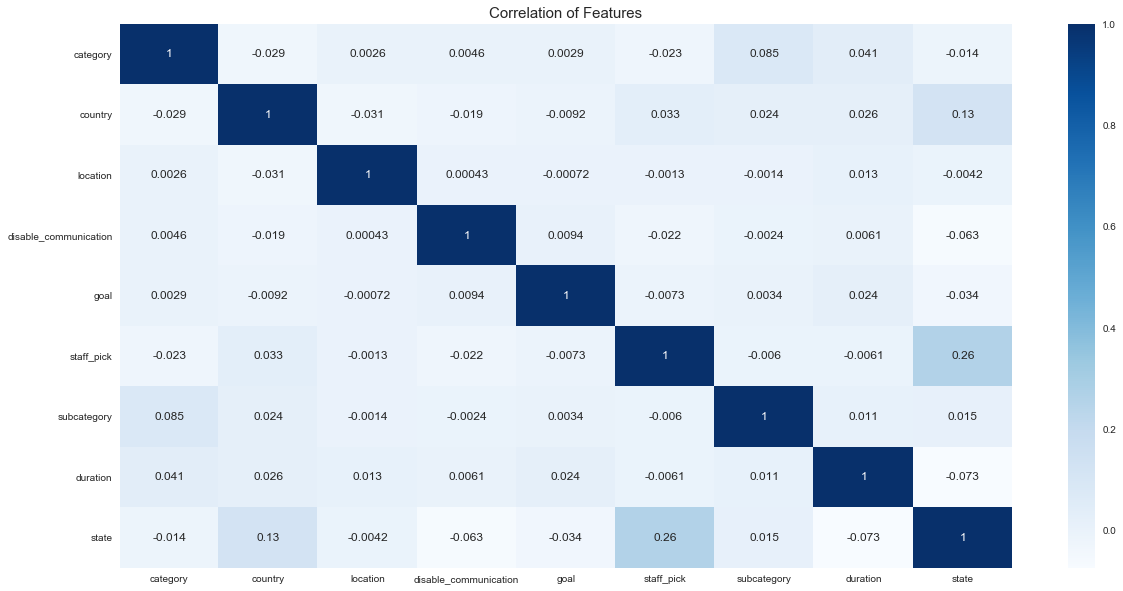

In [31]:
#Create correlation plot
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(),annot=True,cmap="Blues")
plt.title('Correlation of Features', fontsize=15)

In [32]:
#Split inputs and outputs
X=df[['category', 'country', 'disable_communication', 'goal', 'staff_pick',
        'location','subcategory', 'duration']]
y=df['state']

In [33]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print("X_train Shape: {}".format(X_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("Y_train Shape: {}".format(y_train.shape))
print("Y_test Shape: {}".format(y_test.shape))

X_train Shape: (138746, 8)
X_test Shape: (46249, 8)
Y_train Shape: (138746,)
Y_test Shape: (46249,)


<a id='section_5'></a>

## 5. Modeling

Now we can begin training the models. First we establish a baseline accuracy.

In [34]:
y_test.mean()

0.5588012713788406

The number above tells us that if our model classifies every Kickstarter campaign as successful, it will achieve an accuracy of ~56%. The actual model has to do better than this in order to be useful. Because there is no best model for every scenario, we will try a few different approaches and compare them on specific ratios.

In [35]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logpred = logreg.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbcpred = gbc.predict(X_test)

In [36]:
pd.DataFrame(data=[accuracy_score(y_test, logpred),accuracy_score(y_test, knnpred),accuracy_score(y_test, rfcpred),accuracy_score(y_test, gbcpred)],
             index=['Logistic Regression','KNeighbors Classifier','Random Forest Classifier','Gradient Boosting Classifier', ], columns=['accuracy']).sort_values(by = ['accuracy'], ascending = False)

,accuracy
Random Forest Classifier,0.79
Gradient Boosting Classifier,0.76
KNeighbors Classifier,0.62
Logistic Regression,0.62


In [37]:
print(confusion_matrix(y_test, rfcpred))

[[15736  4669]
 [ 5217 20627]]


In [38]:
print(confusion_matrix(y_test, gbcpred))

[[13664  6741]
 [ 4306 21538]]


Our stock models produced some excellent results and can now be tuned to achieve even better outcomes.

In [43]:
grid=dict(max_depth=list(range(15,21)), n_estimators=list(range(100,201,50)), 
          max_features=list(range(3,6)))
search=GridSearchCV(rfc, grid,scoring='accuracy')
search.fit(X_train,y_train)
search.grid_scores_

C:\Users\olegh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77825, std: 0.00092, params: {'max_depth': 15, 'max_features': 3, 'n_estimators': 100},
 mean: 0.77873, std: 0.00021, params: {'max_depth': 15, 'max_features': 3, 'n_estimators': 150},
 mean: 0.77944, std: 0.00056, params: {'max_depth': 15, 'max_features': 3, 'n_estimators': 200},
 mean: 0.78653, std: 0.00097, params: {'max_depth': 15, 'max_features': 4, 'n_estimators': 100},
 mean: 0.78740, std: 0.00073, params: {'max_depth': 15, 'max_features': 4, 'n_estimators': 150},
 mean: 0.78714, std: 0.00102, params: {'max_depth': 15, 'max_features': 4, 'n_estimators': 200},
 mean: 0.78813, std: 0.00191, params: {'max_depth': 15, 'max_features': 5, 'n_estimators': 100},
 mean: 0.78886, std: 0.00127, params: {'max_depth': 15, 'max_features': 5, 'n_estimators': 150},
 mean: 0.78871, std: 0.00099, params: {'max_depth': 15, 'max_features': 5, 'n_estimators': 200},
 mean: 0.78570, std: 0.00158, params: {'max_depth': 16, 'max_features': 3, 'n_estimators': 100},
 mean: 0.78523, std: 0.00132, 

In [44]:
rfc = RandomForestClassifier(max_depth=19, n_estimators=200, max_features=5, n_jobs=-1, random_state=1)
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)
accuracy_score(y_test, rfcpred)

0.8044498259421825

In [45]:
print(confusion_matrix(y_test, rfcpred))

[[15973  4432]
 [ 4612 21232]]


In [46]:
gbc = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100, max_depth=10,random_state=1)
gbc.fit(X_train, y_train)
gbcpred = gbc.predict(X_test)
accuracy_score(y_test, gbcpred)

0.8108283422344267

In [47]:
print(confusion_matrix(y_test, gbcpred))

[[16308  4097]
 [ 4652 21192]]


<a id='section_6'></a>

## 6. Conclusion

Given that Random Forest and Gradient Boosting models obtained an accuracy greater than the baseline 55.8%, we can say that these results are acceptable. If applied to an unknown kickstarter dataset, we could expect to achieve an accuracy of ~80%. With additional time and computing power, the model parameters and training can be oprimized further to achieve better results. With this in mind, for next iterations, I would focus on feature engineering and model tuning to reduce bias and improve accuracy. 